## Import libraries

In [47]:
# standard libraries
import pandas as pd
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None) 
pd.set_option('display.max_rows', 30) 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import seaborn as sns
import math
# plt.figure(figsize=(16,6))  # set the plot size
# plt.ylim(-0.01, 0.04)  # set the axis zoom range
# plt.xlim(-0.01, 0.04)

import warnings
warnings.filterwarnings('ignore')

In [48]:
from pyhive import presto

def get_presto_conn():
    return presto.connect(host='presto-alpha-backend.data.houzz.net', port=8086)

def presto_query(query, presto_conn, fetchall=True):
    cursor = presto_conn.cursor()
    cursor.execute(query)
    header = list(map(operator.itemgetter(0), cursor.description))
    return header, cursor.fetchall()
conn = get_presto_conn() 

In [49]:
%%time
# import daily gmv, spend, cm for each leaf category from 2021
ts = pd.read_sql("""
                select dt, ramp, a.leaf_category, 
                            sum(gmv_w_cancel_est) gmv_w_cancel_est,
                            sum(spend) spend,
                            sum(cm) cm
                from mp.order_item_cm_metrics a
                left join wandajuan.llcm_leaf_split b 
                on a.leaf_category = b.leaf_category 
                where dt >= '2021-01-01'
                group by 1, 2, 3
                """, conn)
ts.head()

CPU times: user 1.49 s, sys: 317 ms, total: 1.81 s
Wall time: 51.6 s


,dt,ramp,leaf_category,gmv_w_cancel_est,spend,cm
0,2021-03-29,T1,metal wall art,1006.06,-108.867609,96.441365
1,2021-04-04,T2,utensil holders and racks,43.00,-3.823986,2.125782
2,2021-04-06,C1,tile murals,2502.00,-116.075663,275.170074
3,2021-04-09,C2,floor mirrors,269.99,-72.805300,-16.536908
4,2021-04-11,T1,decorative boxes,0.00,-18.338755,-14.390755


In [50]:
ts['dt'] = pd.to_datetime(ts['dt'])
ts['year'] = ts['dt'].dt.year
ts['month'] = ts['dt'].dt.to_period('M')
ts['week'] = ts['dt'].dt.to_period('W')
ts.head()

,dt,ramp,leaf_category,gmv_w_cancel_est,spend,cm,year,month,week
0,2021-03-29,T1,metal wall art,1006.06,-108.867609,96.441365,2021,2021-03,2021-03-29/2021-04-04
1,2021-04-04,T2,utensil holders and racks,43.00,-3.823986,2.125782,2021,2021-04,2021-03-29/2021-04-04
2,2021-04-06,C1,tile murals,2502.00,-116.075663,275.170074,2021,2021-04,2021-04-05/2021-04-11
3,2021-04-09,C2,floor mirrors,269.99,-72.805300,-16.536908,2021,2021-04,2021-04-05/2021-04-11
4,2021-04-11,T1,decorative boxes,0.00,-18.338755,-14.390755,2021,2021-04,2021-04-05/2021-04-11


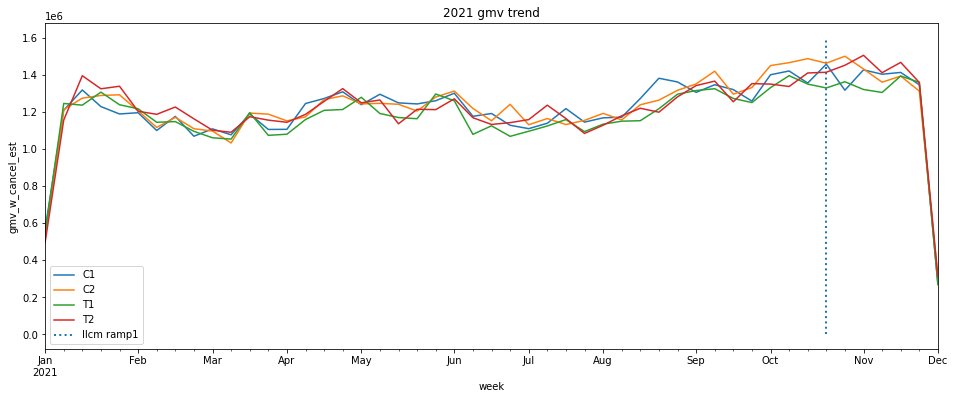

In [52]:
ts_2021 = ts.query('year==2021')
ts_2021.groupby(['week', 'ramp'])['gmv_w_cancel_est'].sum().reset_index().\
        pivot('week', 'ramp', 'gmv_w_cancel_est').plot(figsize=(16, 6))
plt.vlines(x=pd.to_datetime('2021-10-22'), ymin=500, ymax=1600000, linestyle=":", lw=2, label='llcm ramp1')
plt.ylabel('gmv_w_cancel_est')
plt.title('2021 gmv trend')
plt.legend()

## T1

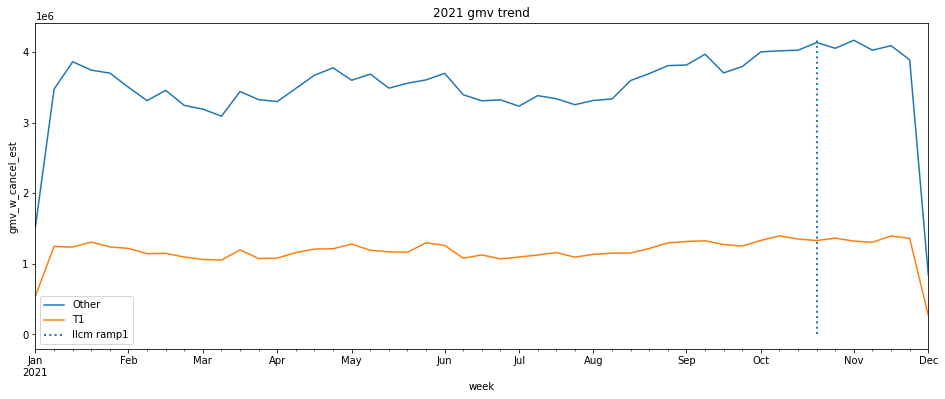

In [54]:
# filter for ramp is not null in 2021 and exclude dining tables
ts_T1 = ts.query('year==2021 and ramp == ramp and leaf_category != "dining tables"') 
ts_T1.assign(T1 = np.where(ts_T1['ramp']=='T1', 'T1', 'Other'))\
        .groupby(['week', 'T1'])['gmv_w_cancel_est'].sum().reset_index().\
        pivot('week', 'T1', 'gmv_w_cancel_est').plot(figsize=(16, 6))
plt.vlines(x=pd.to_datetime('2021-10-22'), ymin=500, ymax=4200000, linestyle=":", lw=2, label='llcm ramp1')
plt.ylabel('gmv_w_cancel_est')
plt.title('2021 gmv trend')
plt.legend()

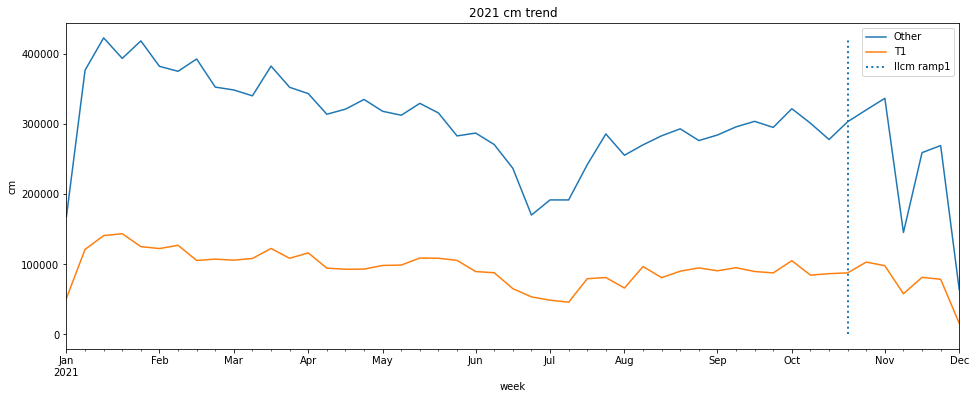

In [55]:
# filter for ramp is not null in 2021 and exclude dining tables
ts_T1 = ts.query('year==2021 and ramp == ramp and leaf_category != "dining tables"') 
ts_T1.assign(T1 = np.where(ts_T1['ramp']=='T1', 'T1', 'Other'))\
        .groupby(['week', 'T1'])['cm'].sum().reset_index().\
        pivot('week', 'T1', 'cm').plot(figsize=(16, 6))
plt.vlines(x=pd.to_datetime('2021-10-22'), ymin=0, ymax=420000, linestyle=":", lw=2, label='llcm ramp1')
plt.ylabel('cm')
plt.title('2021 cm trend')
plt.legend()

GMV and CM look bit correlated between T1 and other group before interference
--> model T1 using other groups on preperiod, and use the model to estimate T1 withou interference

## GMV

### Preperiod 

In [129]:
# metrics = ['gmv_w_cancel_est', 'cm']
# metrics = ['gmv_w_cancel_est']

preperiod = ts_T1.query('dt < "2021-10-22"')\
        .groupby(['week', 'ramp'])['gmv_w_cancel_est'].sum().reset_index()\
        .pivot(index='ramp', columns='week').T

preperiod

ramp                                              C1            C2  \
                 week                                                
gmv_w_cancel_est 2020-12-28/2021-01-03  5.679503e+05  4.655554e+05   
                 2021-01-04/2021-01-10  1.209799e+06  1.107709e+06   
                 2021-01-11/2021-01-17  1.318811e+06  1.146733e+06   
                 2021-01-18/2021-01-24  1.229270e+06  1.188070e+06   
                 2021-01-25/2021-01-31  1.189445e+06  1.172738e+06   
...                                              ...           ...   
                 2021-09-20/2021-09-26  1.258865e+06  1.182752e+06   
                 2021-09-27/2021-10-03  1.401043e+06  1.249758e+06   
                 2021-10-04/2021-10-10  1.421339e+06  1.257523e+06   
                 2021-10-11/2021-10-17  1.356222e+06  1.258727e+06   
                 2021-10-18/2021-10-24  8.612810e+05  7.947655e+05   

ramp                                              T1            T2  
                 week                                               
gmv_w_cancel_est 2020-12-28/2021-01-03  5.459500e+05  4.961958e+05  
                 2021-01-04/2021-01-10  1.246175e+06  1.156339e+06  
                 2021-01-11/2021-01-17  1.237122e+06  1.395835e+06  
                 2021-01-18/2021-01-24  1.307228e+06  1.325327e+06  
                 2021-01-25/2021-01-31  1.239127e+06  1.339064e+06  
...                                              ...           ...  
                 2021-09-20/2021-09-26  1.250993e+06  1.353102e+06  
                 2021-09-27/2021-10-03  1.331529e+06  1.350660e+06  
                 2021-10-04/2021-10-10  1.396075e+06  1.337711e+06  
                 2021-10-11/2021-10-17  1.350789e+06  1.410518e+06  
                 2021-10-18/2021-10-24  8.011784e+05  8.609557e+05  

[43 rows x 4 columns]

In [130]:
y_train = preperiod['T1'].values
X_train = preperiod.drop(columns='T1').values
y_train.shape, X_train.shape

((43,), (43, 3))

In [134]:
from sklearn.linear_model import Lasso
clf = Lasso().fit(X_train, y_train)
weights_lr = clf.coef_
weights_lr
from sklearn.metrics import r2_score
r2_score(y_train, clf.predict(X_train))

0.9329101300997987

### Apply the model to all period and plot

In [135]:
allperiod = ts_2021.groupby(['week', 'ramp'])['gmv_w_cancel_est'].sum().reset_index()\
                    .pivot(index='ramp', columns='week').T
allperiod

ramp                                              C1            C2  \
                 week                                                
gmv_w_cancel_est 2020-12-28/2021-01-03  5.679503e+05  5.254428e+05   
                 2021-01-04/2021-01-10  1.209799e+06  1.212849e+06   
                 2021-01-11/2021-01-17  1.318811e+06  1.274835e+06   
                 2021-01-18/2021-01-24  1.229270e+06  1.289282e+06   
                 2021-01-25/2021-01-31  1.189445e+06  1.292874e+06   
...                                              ...           ...   
                 2021-11-01/2021-11-07  1.427371e+06  1.431904e+06   
                 2021-11-08/2021-11-14  1.403914e+06  1.360907e+06   
                 2021-11-15/2021-11-21  1.413489e+06  1.393825e+06   
                 2021-11-22/2021-11-28  1.347160e+06  1.312828e+06   
                 2021-11-29/2021-12-05  2.704678e+05  3.082314e+05   

ramp                                              T1            T2  
                 week                                               
gmv_w_cancel_est 2020-12-28/2021-01-03  5.459500e+05  4.961958e+05  
                 2021-01-04/2021-01-10  1.246175e+06  1.156339e+06  
                 2021-01-11/2021-01-17  1.237122e+06  1.395835e+06  
                 2021-01-18/2021-01-24  1.307228e+06  1.325327e+06  
                 2021-01-25/2021-01-31  1.239127e+06  1.339064e+06  
...                                              ...           ...  
                 2021-11-01/2021-11-07  1.321531e+06  1.505869e+06  
                 2021-11-08/2021-11-14  1.305375e+06  1.412200e+06  
                 2021-11-15/2021-11-21  1.394256e+06  1.467674e+06  
                 2021-11-22/2021-11-28  1.360077e+06  1.359319e+06  
                 2021-11-29/2021-12-05  2.690977e+05  3.115853e+05  

[49 rows x 4 columns]

In [136]:
y_actual = allperiod['T1'].values
X_all = allperiod.drop(columns='T1').values
y_actual.shape, X_all.shape

((49,), (49, 3))

In [137]:
y_pred = clf.predict(X_all)
r2_score(y_actual, y_pred)

0.8429252960309197

In [138]:
y_all = pd.DataFrame(index=allperiod.index.get_level_values(1), \
                    columns=['T1 pred', 'T1 actual'], \
                    data = np.array([y_pred, y_actual]).T)
y_all

,T1 pred,T1 actual
week,,
2020-12-28/2021-01-03,5.518871e+05,5.459500e+05
2021-01-04/2021-01-10,1.221268e+06,1.246175e+06
2021-01-11/2021-01-17,1.340028e+06,1.237122e+06
2021-01-18/2021-01-24,1.297112e+06,1.307228e+06
2021-01-25/2021-01-31,1.286684e+06,1.239127e+06
...,...,...
2021-11-01/2021-11-07,1.469812e+06,1.321531e+06
2021-11-08/2021-11-14,1.411157e+06,1.305375e+06
2021-11-15/2021-11-21,1.440493e+06,1.394256e+06


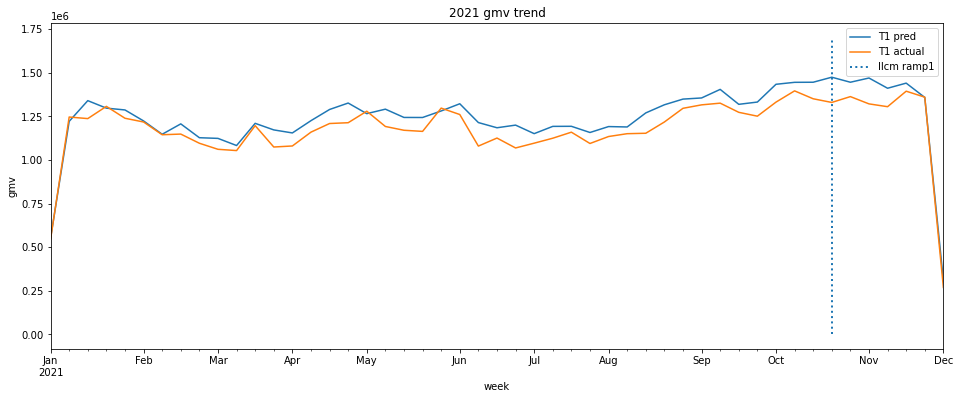

In [139]:
y_all.plot(figsize=(16, 6))
plt.vlines(x=pd.to_datetime('2021-10-22'), ymin=0, ymax=1700000, linestyle=":", lw=2, label='llcm ramp1')
plt.ylabel('gmv')
plt.title('2021 gmv trend')
plt.legend()

In [143]:
y_all[y_all.index<'2021-10-22'].diff(axis=1).sum()/y_all[y_all.index<'2021-10-22'].shape[0]/7

T1 pred         0.000000
T1 actual   -8300.138872
dtype: float64

In [140]:
y_all[y_all.index>'2021-10-22'].diff(axis=1).sum()

T1 pred           0.000000
T1 actual   -422111.277212
dtype: float64

In [141]:
y_all[y_all.index>'2021-10-22'].diff(axis=1).sum()/y_all[y_all.index>'2021-10-22'].shape[0]/7

T1 pred          0.000000
T1 actual   -10050.268505
dtype: float64

## CM
### Preperiod 

In [117]:
preperiod_cm = ts_T1.query('dt < "2021-10-22"')\
        .groupby(['week', 'ramp'])['cm'].sum().reset_index()\
        .pivot(index='ramp', columns='week').T

preperiod_cm

ramp                                 C1             C2             T1  \
   week                                                                 
cm 2020-12-28/2021-01-03   64375.564790   57299.060628   51677.047945   
   2021-01-04/2021-01-10  128822.287613  143109.223747  121333.394940   
   2021-01-11/2021-01-17  141146.422225  138986.860629  141029.953821   
   2021-01-18/2021-01-24  135509.187356  143852.327199  143766.642209   
   2021-01-25/2021-01-31  134687.533898  141045.938729  125348.204953   
...                                 ...            ...            ...   
   2021-09-20/2021-09-26   85870.604802  101280.649260   87783.806424   
   2021-09-27/2021-10-03  107609.267741  107215.177973  105203.362982   
   2021-10-04/2021-10-10   97466.304253  107236.965554   84632.699309   
   2021-10-11/2021-10-17   81808.744130   90549.878664   86708.762585   
   2021-10-18/2021-10-24   57485.349913   66018.878948   50624.894795   

ramp                                 T2  
   week                                  
cm 2020-12-28/2021-01-03   46733.390867  
   2021-01-04/2021-01-10  105298.818165  
   2021-01-11/2021-01-17  143322.720810  
   2021-01-18/2021-01-24  114792.039683  
   2021-01-25/2021-01-31  143405.077125  
...                                 ...  
   2021-09-20/2021-09-26  108415.614199  
   2021-09-27/2021-10-03  107434.622693  
   2021-10-04/2021-10-10   96886.445622  
   2021-10-11/2021-10-17  105925.568990  
   2021-10-18/2021-10-24   61813.343989  

[43 rows x 4 columns]

In [118]:
y_train = preperiod_cm['T1'].values
X_train = preperiod_cm.drop(columns='T1').values
y_train.shape, X_train.shape

clf_cm = Lasso(alpha=1).fit(X_train, y_train)
r2_score(y_train, clf_cm.predict(X_train))

0.9082076424586993

### Apply the model

In [119]:
allperiod_cm = ts_2021.groupby(['week', 'ramp'])['cm'].sum().reset_index()\
                    .pivot(index='ramp', columns='week').T
y_actual = allperiod_cm['T1'].values
X_all = allperiod_cm.drop(columns='T1').values
y_actual.shape, X_all.shape

((49,), (49, 3))

In [120]:
y_pred = clf_cm.predict(X_all)
r2_score(y_actual, y_pred)

0.9137786414212944

In [121]:
y_all = pd.DataFrame(index=allperiod_cm.index.get_level_values(1), \
                    columns=['T1 pred', 'T1 actual'], \
                    data = np.array([y_pred, y_actual]).T)
y_all

,T1 pred,T1 actual
week,,
2020-12-28/2021-01-03,52163.742051,51677.047945
2021-01-04/2021-01-10,126961.428017,121333.394940
2021-01-11/2021-01-17,139775.159041,141029.953821
2021-01-18/2021-01-24,134528.998717,143766.642209
2021-01-25/2021-01-31,135154.473123,125348.204953
...,...,...
2021-11-01/2021-11-07,106139.431840,98079.574843
2021-11-08/2021-11-14,53677.398637,57981.177648
2021-11-15/2021-11-21,79767.953964,81457.801599


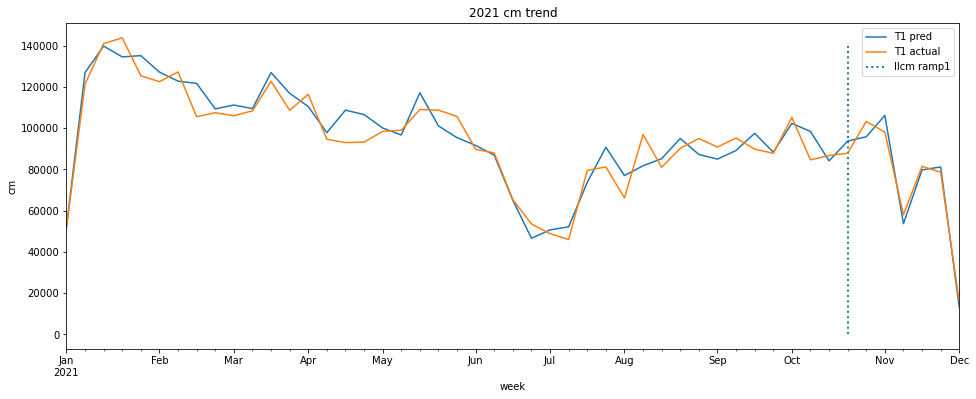

In [122]:
y_all.plot(figsize=(16, 6))
plt.vlines(x=pd.to_datetime('2021-10-22'), ymin=0, ymax=140000, linestyle=":", lw=2, label='llcm ramp1')
plt.ylabel('cm')
plt.title('2021 cm trend')
plt.legend()

In [128]:
y_all[y_all.index>'2021-10-22'].diff(axis=1).sum()/y_all[y_all.index>'2021-10-22'].shape[0]/7

T1 pred        0.000000
T1 actual    131.293276
dtype: float64

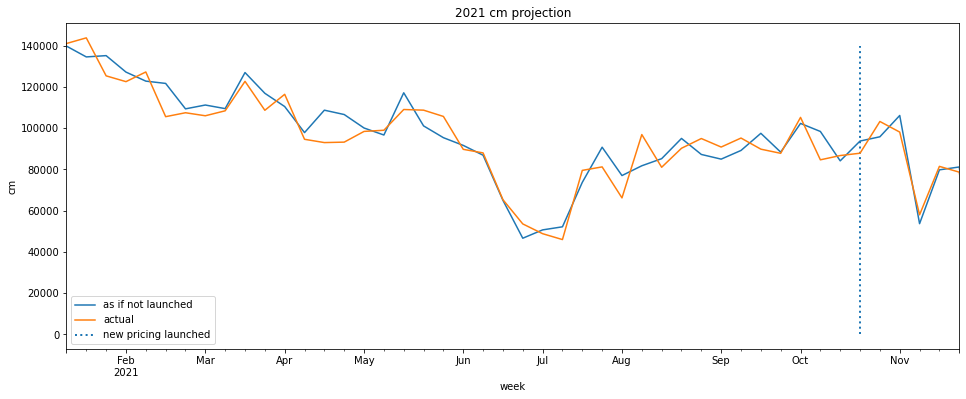

In [126]:
y_all.plot(figsize=(16, 6))
plt.vlines(x=pd.to_datetime('2021-10-22'), ymin=0, ymax=140000, linestyle=":", lw=2, label='llcm ramp1')
plt.ylabel('cm')
plt.xlim('2021-01-11', "2021-11-28")
plt.title('2021 cm projection')
plt.legend(['as if not launched', 'actual', 'new pricing launched'], loc=3)